In [1]:

import tensorflow as tf
import numpy as np
import random
import os

In [2]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [3]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [4]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [6]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_1HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '98.mat')
  X098_normal = scipy.io.loadmat(file_path1)['X098_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

 

  file_path2 = os.path.join(folder_path, '110.mat')
  X110_InnerRace_007  = scipy.io.loadmat(file_path2)['X110_DE_time']
  # mat_data = scipy.io.loadmat(file_path2)
  # print(mat_data.keys())

  file_path2 = os.path.join(folder_path, '123.mat')
  X123_Ball_007  = scipy.io.loadmat(file_path2)['X123_DE_time']

  file_path3 = os.path.join(folder_path, '136.mat')
  X136_Outer_007 = scipy.io.loadmat(file_path3)['X136_DE_time']

  file_path6 = os.path.join(folder_path, '175.mat')
  X175_InnerRace_014 = scipy.io.loadmat(file_path6)['X175_DE_time']
    
  file_path7 = os.path.join(folder_path, '190.mat')
  X190_Ball_014 = scipy.io.loadmat(file_path7)['X190_DE_time']

  file_path8 = os.path.join(folder_path, '202.mat')
  X202_Outer_014  = scipy.io.loadmat(file_path8)['X202_DE_time']
    
  file_path9 = os.path.join(folder_path, '214.mat')
  X214_InnerRace_021  = scipy.io.loadmat(file_path9)['X214_DE_time']

  file_path10 = os.path.join(folder_path, '227.mat')
  X227_Ball_021  = scipy.io.loadmat(file_path10)['X227_DE_time'] 

  file_path11 = os.path.join(folder_path, '239.mat')
  X239_Outer_021  = scipy.io.loadmat(file_path11)['X239_DE_time'] 
    
  return [X098_normal,X110_InnerRace_007,X123_Ball_007,X136_Outer_007,X175_InnerRace_014,X190_Ball_014,X202_Outer_014,X214_InnerRace_021,X227_Ball_021,X239_Outer_021]

In [7]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [8]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

In [9]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
interval_length = 320 #320 #290 #200  
samples_per_block = 1600 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (483903, 1)
Dataset 2 shape: (486224, 1)
Dataset 3 shape: (487384, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (381890, 1)
Dataset 6 shape: (486224, 1)
Dataset 7 shape: (484483, 1)
Dataset 8 shape: (485063, 1)
Dataset 9 shape: (486804, 1)
Dataset 10 shape: (489125, 1)
[[ 4.61040000e-02 -3.71335385e-02 -8.94960000e-02 ...  4.71470769e-02
  -1.25169231e-03 -7.13464615e-02]
 [-9.05390769e-02 -8.11513846e-02 -5.65347692e-02 ... -3.21267692e-02
  -6.25846154e-04 -1.58547692e-02]
 [ 3.54646154e-02  3.85938462e-02  6.13329231e-02 ...  6.04984615e-02
   6.94689231e-02  8.61581538e-02]
 ...
 [-2.33706667e-02 -2.42053333e-02 -2.00320000e-02 ... -2.26194667e-01
  -4.98296000e-01 -6.88600000e-01]
 [-2.25360000e-02  3.92293333e-02  8.17973333e-02 ...  1.29373333e-01
   5.17493333e-02 -9.18133333e-03]
 [ 3.54733333e-01  2.68762667e-01  2.18682667e-01 ...  5.59226667e-02
  -3.33866667e-03 -5.59226667e-02]]
Shape of Input Data = (14807, 1600)
Shape of Label Y_CNN = (14807, 10)
Sh

In [10]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,40,40,1])

# Input_2D = X_image.reshape([-1,96,96,1])
print(Input_2D.shape)

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(40,40,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

(14807, 40, 40, 1)


In [11]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp6/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-10 08:25:28.113214: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:25:28.114242: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5014 - loss: 1.3045

2025-06-10 08:25:43.133604: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:25:43.134035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.85775, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.5028 - loss: 1.3009 - val_accuracy: 0.8577 - val_loss: 0.3503
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9113 - loss: 0.2632
Epoch 2: val_accuracy improved from 0.85775 to 0.90756, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2629 - val_accuracy: 0.9076 - val_loss: 0.2261
Epoch 3/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9390 - loss: 0.1569
Epoch 3: val_accuracy improved from 0.90756 to 0.95526, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9390 - loss: 0.1568 - val_accuracy: 0.9553 - val_loss: 0.1188
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9613 - loss: 0.1130
Epoch 4: val_accuracy did not improve from 0.95526
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9613 - loss: 0.1129 - val_accuracy: 0.9287 - val_loss: 0.3968
Epoch 5/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9644 - loss: 0.1037
Epoch 5: val_accuracy improved from 0.95526 to 0.97256, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9645 - loss: 0.1035 - val_accuracy: 0.9726 - val_loss: 0.0899
Epoch 6/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9663 - loss: 0.0925
Epoch 6: val_accuracy improved from 0.97256 to 0.97932, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9663 - loss: 0.0923 - val_accuracy: 0.9793 - val_loss: 0.0477
Epoch 7/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9879 - loss: 0.0325
Epoch 7: val_accuracy did not improve from 0.97932
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9879 - loss: 0.0326 - val_accuracy: 0.9768 - val_loss: 0.0609
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9889 - loss: 0.0331
Epoch 8: val_accuracy improved from 0.97932 to 0.99240, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9889 - loss: 0.0331 - val_accuracy: 0.9924 - val_loss: 0.0249
Epoch 9/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9873 - loss: 0.0388
Epoch 9: val_accuracy improved from 0.99240 to 0.99325, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9873 - loss: 0.0388 - val_accuracy: 0.9932 - val_loss: 0.0225
Epoch 10/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9862 - loss: 0.0408
Epoch 10: val_accuracy improved from 0.99325 to 0.99578, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9862 - loss: 0.0408 - val_accuracy: 0.9958 - val_loss: 0.0158
Epoch 11/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9964 - loss: 0.0120
Epoch 11: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.9865 - val_loss: 0.0464
Epoch 12/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9890 - loss: 0.0310
Epoch 12: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9890 - loss: 0.0310 - val_accuracy: 0.9954 - val_loss: 0.0172
Epoch 13/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9939 - loss: 0.0208
Epoch 13: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9939 - loss: 0.0208 - val_accuracy: 0.9958 - val_loss: 0.0141
Epoch 14/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9985 - loss: 0.0045
Epoch 14: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9903 - loss: 0.0315 - val_accuracy: 0.9966 - val_loss: 0.0091
Epoch 16/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9936 - loss: 0.0253
Epoch 16: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9936 - loss: 0.0254 - val_accuracy: 0.9966 - val_loss: 0.0102
Epoch 17/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9987 - loss: 0.0056
Epoch 17: val_accuracy improved from 0.99662 to 0.99831, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_1.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9983 - val_loss: 0.0062
Epoch 18/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9993 - loss: 0.0026
Epoch 18: val_accuracy did not improve from 0.99831
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9962 - val_loss: 0.0137
Epoch 19/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9991 - loss: 0.0035
Epoch 19: val_accuracy did not improve from 0.99831
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9966 - val_loss: 0.0081
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 7.2335e-04
Epoch 20: val_accuracy did not improve from 0.99831
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 1.0000 - loss: 7.2060e-04 - val_accuracy: 0.9975 - val_loss: 0.0055
Epoch 21/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 9.0247e-05


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 1.0000 - loss: 7.4834e-08 - val_accuracy: 0.9987 - val_loss: 0.0063
Epoch 54/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 6.3314e-08
Epoch 54: val_accuracy did not improve from 0.99873
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 1.0000 - loss: 6.3319e-08 - val_accuracy: 0.9987 - val_loss: 0.0064
Epoch 55/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 5.3936e-08
Epoch 55: val_accuracy did not improve from 0.99873
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 1.0000 - loss: 5.3939e-08 - val_accuracy: 0.9987 - val_loss: 0.0064
Epoch 56/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 4.6095e-08
Epoch 56: val_accuracy did not improve from 0.99873
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 1.0000 - loss: 4.6097e-08 - val_accuracy: 0.9987 - val_loss: 0.0065
Epoch 57/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000

Best model loaded successfully!


2025-06-10 08:53:59.644180: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:53:59.647359: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 1.0000 - loss: 6.0354e-08
11/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9997 - loss: 0.0029    

2025-06-10 08:54:09.522815: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:54:09.523331: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9990 - loss: 0.0076
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9996 - loss: 0.0015
Epoch 1/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4912 - loss: 1.3335

2025-06-10 08:54:33.004118: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:54:33.005494: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.87547, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.4919 - loss: 1.3316 - val_accuracy: 0.8755 - val_loss: 0.3105
Epoch 2/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8841 - loss: 0.2973
Epoch 2: val_accuracy improved from 0.87547 to 0.93162, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.8842 - loss: 0.2971 - val_accuracy: 0.9316 - val_loss: 0.1528
Epoch 3/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9307 - loss: 0.1679
Epoch 3: val_accuracy improved from 0.93162 to 0.94639, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9308 - loss: 0.1679 - val_accuracy: 0.9464 - val_loss: 0.1344
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9598 - loss: 0.1037
Epoch 4: val_accuracy improved from 0.94639 to 0.94977, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9598 - loss: 0.1036 - val_accuracy: 0.9498 - val_loss: 0.1265
Epoch 5/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9751 - loss: 0.0683
Epoch 5: val_accuracy improved from 0.94977 to 0.96032, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9751 - loss: 0.0683 - val_accuracy: 0.9603 - val_loss: 0.1133
Epoch 6/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9753 - loss: 0.0693
Epoch 6: val_accuracy improved from 0.96032 to 0.98565, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9753 - loss: 0.0692 - val_accuracy: 0.9856 - val_loss: 0.0358
Epoch 7/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9813 - loss: 0.0501
Epoch 7: val_accuracy did not improve from 0.98565
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9813 - loss: 0.0501 - val_accuracy: 0.9574 - val_loss: 0.1056
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9881 - loss: 0.0367
Epoch 8: val_accuracy improved from 0.98565 to 0.99198, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9881 - loss: 0.0368 - val_accuracy: 0.9920 - val_loss: 0.0273
Epoch 9/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9931 - loss: 0.0207
Epoch 9: val_accuracy did not improve from 0.99198
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9931 - loss: 0.0207 - val_accuracy: 0.9489 - val_loss: 0.1448
Epoch 10/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9929 - loss: 0.0195
Epoch 10: val_accuracy did not improve from 0.99198
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9929 - loss: 0.0195 - val_accuracy: 0.9899 - val_loss: 0.0266
Epoch 11/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9934 - loss: 0.0201
Epoch 11: val_accuracy did not improve from 0.99198
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9933 - loss: 0.0205 - val_accuracy: 0.9709 - val_loss: 0.1063
Epoch 12/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9822 - loss: 0.0571
Epoch 12: val_

297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9822 - loss: 0.0570 - val_accuracy: 0.9954 - val_loss: 0.0162
Epoch 13/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9922 - loss: 0.0245
Epoch 13: val_accuracy did not improve from 0.99536
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9922 - loss: 0.0245 - val_accuracy: 0.9941 - val_loss: 0.0151
Epoch 14/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9949 - loss: 0.0137
Epoch 14: val_accuracy did not improve from 0.99536
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9949 - loss: 0.0137 - val_accuracy: 0.9882 - val_loss: 0.0313
Epoch 15/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9924 - loss: 0.0226
Epoch 15: val_accuracy did not improve from 0.99536
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9924 - loss: 0.0226 - val_accuracy: 0.9924 - val_loss: 0.0214
Epoch 16/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9953 - loss: 0.0137
Epoch 16: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9961 - loss: 0.0097 - val_accuracy: 0.9979 - val_loss: 0.0061
Epoch 19/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9990 - loss: 0.0021
Epoch 19: val_accuracy did not improve from 0.99789
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9990 - loss: 0.0021 - val_accuracy: 0.9979 - val_loss: 0.0057
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 3.0965e-04
Epoch 20: val_accuracy improved from 0.99789 to 0.99873, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 1.0000 - loss: 3.0883e-04 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 21/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.2539e-04
Epoch 21: val_accuracy improved from 0.99873 to 0.99916, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_2.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 1.0000 - loss: 1.2524e-04 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 22/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 8.4668e-05
Epoch 22: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 1.0000 - loss: 8.4582e-05 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 23/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 6.0736e-05
Epoch 23: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 6.0683e-05 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 24/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 4.5217e-05
Epoch 24: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 1.0000 - loss: 4.5168e-05 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 25/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000

297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 1.0000 - loss: 1.4953e-06 - val_accuracy: 0.9996 - val_loss: 0.0031
Epoch 42/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 1.2184e-06
Epoch 42: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 1.0000 - loss: 1.2172e-06 - val_accuracy: 0.9996 - val_loss: 0.0030
Epoch 43/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 9.9079e-07
Epoch 43: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 9.8987e-07 - val_accuracy: 0.9996 - val_loss: 0.0030
Epoch 44/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 8.1096e-07
Epoch 44: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 8.1022e-07 - val_accuracy: 0.9996 - val_loss: 0.0030
Epoch 45/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000

Best model loaded successfully!
 5/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

2025-06-10 09:14:14.938759: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 09:14:14.940025: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 1.1363e-06
15/75 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0012    

2025-06-10 09:14:20.436861: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:14:20.437238: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9998 - loss: 0.0017
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.6579e-05
Epoch 1/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5185 - loss: 1.2811

2025-06-10 09:14:36.920488: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:14:36.920835: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.91473, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.5199 - loss: 1.2774 - val_accuracy: 0.9147 - val_loss: 0.2370
Epoch 2/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9020 - loss: 0.2627
Epoch 2: val_accuracy improved from 0.91473 to 0.95399, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9021 - loss: 0.2623 - val_accuracy: 0.9540 - val_loss: 0.1259
Epoch 3/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9495 - loss: 0.1379
Epoch 3: val_accuracy did not improve from 0.95399
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9496 - loss: 0.1378 - val_accuracy: 0.9232 - val_loss: 0.2006
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9654 - loss: 0.0947
Epoch 4: val_accuracy improved from 0.95399 to 0.98227, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9654 - loss: 0.0946 - val_accuracy: 0.9823 - val_loss: 0.0517
Epoch 5/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9706 - loss: 0.0879
Epoch 5: val_accuracy did not improve from 0.98227
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9706 - loss: 0.0879 - val_accuracy: 0.9126 - val_loss: 0.2654
Epoch 6/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9774 - loss: 0.0690
Epoch 6: val_accuracy did not improve from 0.98227
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9774 - loss: 0.0689 - val_accuracy: 0.9814 - val_loss: 0.0521
Epoch 7/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9834 - loss: 0.0495
Epoch 7: val_accuracy improved from 0.98227 to 0.98776, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9834 - loss: 0.0495 - val_accuracy: 0.9878 - val_loss: 0.0426
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9836 - loss: 0.0516
Epoch 8: val_accuracy did not improve from 0.98776
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9837 - loss: 0.0515 - val_accuracy: 0.9721 - val_loss: 0.0742
Epoch 9/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9909 - loss: 0.0283
Epoch 9: val_accuracy improved from 0.98776 to 0.99198, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9909 - loss: 0.0282 - val_accuracy: 0.9920 - val_loss: 0.0274
Epoch 10/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9912 - loss: 0.0279
Epoch 10: val_accuracy did not improve from 0.99198
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9911 - loss: 0.0282 - val_accuracy: 0.9751 - val_loss: 0.0765
Epoch 11/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9844 - loss: 0.0492
Epoch 11: val_accuracy did not improve from 0.99198
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9845 - loss: 0.0490 - val_accuracy: 0.9869 - val_loss: 0.0388
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9916 - loss: 0.0242
Epoch 12: val_accuracy did not improve from 0.99198
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9916 - loss: 0.0242 - val_accuracy: 0.9920 - val_loss: 0.0305
Epoch 13/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9968 - loss: 0.0101
Epoch 13: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9933 - loss: 0.0162 - val_accuracy: 0.9954 - val_loss: 0.0112
Epoch 15/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9976 - loss: 0.0078
Epoch 15: val_accuracy improved from 0.99536 to 0.99789, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9976 - loss: 0.0078 - val_accuracy: 0.9979 - val_loss: 0.0072
Epoch 16/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9989 - loss: 0.0030
Epoch 16: val_accuracy did not improve from 0.99789
297/297 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9937 - val_loss: 0.0246
Epoch 17/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9846 - loss: 0.0520
Epoch 17: val_accuracy did not improve from 0.99789
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9846 - loss: 0.0519 - val_accuracy: 0.9620 - val_loss: 0.1270
Epoch 18/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9483 - loss: 0.2316
Epoch 18: val_accuracy improved from 0.99789 to 0.99831, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_3.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9485 - loss: 0.2307 - val_accuracy: 0.9983 - val_loss: 0.0097
Epoch 19/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9989 - loss: 0.0045
Epoch 19: val_accuracy did not improve from 0.99831
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.9975 - val_loss: 0.0111
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9970 - loss: 0.0108
Epoch 20: val_accuracy did not improve from 0.99831
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9865 - val_loss: 0.0418
Epoch 21/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9937 - loss: 0.0192
Epoch 21: val_accuracy did not improve from 0.99831
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9937 - loss: 0.0191 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 22/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 7.3112e-04
Epoch 22

297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 1.0000 - loss: 6.1031e-05 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 27/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 3.8404e-05
Epoch 27: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 1.0000 - loss: 3.8454e-05 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 28/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.9332e-05
Epoch 28: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 2.9364e-05 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 29/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.3384e-05
Epoch 29: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 2.3406e-05 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 30/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000

Best model loaded successfully!
10/75 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-06-10 09:32:51.879924: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 09:32:51.880672: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 6.5527e-05
16/75 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9975 - loss: 0.0039

2025-06-10 09:32:57.160338: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:32:57.160676: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9988 - loss: 0.0025
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9993 - loss: 0.0014
Epoch 1/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4765 - loss: 1.2996

2025-06-10 09:33:12.747832: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:33:12.748209: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.87547, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4780 - loss: 1.2962 - val_accuracy: 0.8755 - val_loss: 0.3122
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8892 - loss: 0.2833
Epoch 2: val_accuracy improved from 0.87547 to 0.96285, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8894 - loss: 0.2830 - val_accuracy: 0.9629 - val_loss: 0.1031
Epoch 3/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9497 - loss: 0.1446
Epoch 3: val_accuracy improved from 0.96285 to 0.96792, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9498 - loss: 0.1444 - val_accuracy: 0.9679 - val_loss: 0.0891
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9681 - loss: 0.0912
Epoch 4: val_accuracy did not improve from 0.96792
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9681 - loss: 0.0911 - val_accuracy: 0.9671 - val_loss: 0.1000
Epoch 5/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9688 - loss: 0.0903
Epoch 5: val_accuracy did not improve from 0.96792
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9688 - loss: 0.0902 - val_accuracy: 0.9548 - val_loss: 0.1186
Epoch 6/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9777 - loss: 0.0647
Epoch 6: val_accuracy improved from 0.96792 to 0.98649, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9777 - loss: 0.0646 - val_accuracy: 0.9865 - val_loss: 0.0312
Epoch 7/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9857 - loss: 0.0410
Epoch 7: val_accuracy did not improve from 0.98649
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9857 - loss: 0.0410 - val_accuracy: 0.9717 - val_loss: 0.0755
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9886 - loss: 0.0328
Epoch 8: val_accuracy improved from 0.98649 to 0.99114, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9886 - loss: 0.0329 - val_accuracy: 0.9911 - val_loss: 0.0306
Epoch 9/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9909 - loss: 0.0247
Epoch 9: val_accuracy improved from 0.99114 to 0.99367, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9909 - loss: 0.0247 - val_accuracy: 0.9937 - val_loss: 0.0142
Epoch 10/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9957 - loss: 0.0136
Epoch 10: val_accuracy improved from 0.99367 to 0.99578, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9957 - loss: 0.0136 - val_accuracy: 0.9958 - val_loss: 0.0109
Epoch 11/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9905 - loss: 0.0306
Epoch 11: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9904 - loss: 0.0307 - val_accuracy: 0.9764 - val_loss: 0.0581
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9876 - loss: 0.0296
Epoch 12: val_accuracy did not improve from 0.99578
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9876 - loss: 0.0296 - val_accuracy: 0.9650 - val_loss: 0.1013
Epoch 13/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9933 - loss: 0.0188
Epoch 13: val_accuracy improved from 0.99578 to 0.99662, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_4.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9933 - loss: 0.0188 - val_accuracy: 0.9966 - val_loss: 0.0078
Epoch 14/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9952 - loss: 0.0143
Epoch 14: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9952 - loss: 0.0143 - val_accuracy: 0.9835 - val_loss: 0.0510
Epoch 15/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9927 - loss: 0.0205
Epoch 15: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9927 - loss: 0.0205 - val_accuracy: 0.9818 - val_loss: 0.0647
Epoch 16/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9844 - loss: 0.0581
Epoch 16: val_accuracy did not improve from 0.99662
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9845 - loss: 0.0580 - val_accuracy: 0.9954 - val_loss: 0.0122
Epoch 17/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9929 - loss: 0.0206
Epoch 17: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9929 - loss: 0.0206 - val_accuracy: 0.9996 - val_loss: 0.0036
Epoch 18/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9971 - loss: 0.0092
Epoch 18: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9983 - val_loss: 0.0050
Epoch 19/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9997 - loss: 0.0022
Epoch 19: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.9979 - val_loss: 0.0043
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 6.9482e-04
Epoch 20: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 1.0000 - loss: 6.9294e-04 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 21/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 2.5901e-04


Best model loaded successfully!
 1/75 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step

2025-06-10 09:48:25.692011: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 09:48:25.694506: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9999 - loss: 0.0017
14/75 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0040

2025-06-10 09:48:32.133920: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:48:32.134243: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9995 - loss: 0.0036
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9993 - loss: 0.0044
Epoch 1/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5240 - loss: 1.2335

2025-06-10 09:48:49.887207: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 09:48:49.887782: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.67117, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5254 - loss: 1.2299 - val_accuracy: 0.6712 - val_loss: 1.0292
Epoch 2/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8612 - loss: 0.3907
Epoch 2: val_accuracy improved from 0.67117 to 0.95526, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.8615 - loss: 0.3898 - val_accuracy: 0.9553 - val_loss: 0.1415
Epoch 3/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9449 - loss: 0.1546
Epoch 3: val_accuracy improved from 0.95526 to 0.97721, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9450 - loss: 0.1545 - val_accuracy: 0.9772 - val_loss: 0.0727
Epoch 4/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9663 - loss: 0.0918
Epoch 4: val_accuracy improved from 0.97721 to 0.98269, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9664 - loss: 0.0917 - val_accuracy: 0.9827 - val_loss: 0.0477
Epoch 5/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9815 - loss: 0.0524
Epoch 5: val_accuracy improved from 0.98269 to 0.98818, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9815 - loss: 0.0525 - val_accuracy: 0.9882 - val_loss: 0.0303
Epoch 6/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9852 - loss: 0.0458
Epoch 6: val_accuracy improved from 0.98818 to 0.98945, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9852 - loss: 0.0459 - val_accuracy: 0.9894 - val_loss: 0.0261
Epoch 7/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9835 - loss: 0.0511
Epoch 7: val_accuracy improved from 0.98945 to 0.99156, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9835 - loss: 0.0511 - val_accuracy: 0.9916 - val_loss: 0.0210
Epoch 8/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9895 - loss: 0.0290
Epoch 8: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9895 - loss: 0.0291 - val_accuracy: 0.9823 - val_loss: 0.0592
Epoch 9/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9781 - loss: 0.0672
Epoch 9: val_accuracy did not improve from 0.99156
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9781 - loss: 0.0671 - val_accuracy: 0.9903 - val_loss: 0.0255
Epoch 10/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9945 - loss: 0.0154
Epoch 10: val_accuracy improved from 0.99156 to 0.99325, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9945 - loss: 0.0154 - val_accuracy: 0.9932 - val_loss: 0.0214
Epoch 11/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9966 - loss: 0.0092
Epoch 11: val_accuracy did not improve from 0.99325
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9966 - loss: 0.0092 - val_accuracy: 0.9764 - val_loss: 0.0879
Epoch 12/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9796 - loss: 0.0568
Epoch 12: val_accuracy improved from 0.99325 to 0.99873, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9797 - loss: 0.0567 - val_accuracy: 0.9987 - val_loss: 0.0069
Epoch 13/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9985 - loss: 0.0051
Epoch 13: val_accuracy did not improve from 0.99873
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.9531 - val_loss: 0.1706
Epoch 14/200
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9901 - loss: 0.0287
Epoch 14: val_accuracy did not improve from 0.99873
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9901 - loss: 0.0286 - val_accuracy: 0.9958 - val_loss: 0.0127
Epoch 15/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9979 - loss: 0.0059
Epoch 15: val_accuracy improved from 0.99873 to 0.99916, saving model to CNN2D_results/V4_2_NOL_exp6/best_model_5.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9979 - loss: 0.0059 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 16/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9931 - loss: 0.0202
Epoch 16: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9931 - loss: 0.0203 - val_accuracy: 0.9983 - val_loss: 0.0041
Epoch 17/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9984 - loss: 0.0038
Epoch 17: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.9954 - val_loss: 0.0114
Epoch 18/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9997 - loss: 0.0017
Epoch 18: val_accuracy did not improve from 0.99916
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9975 - val_loss: 0.0077
Epoch 19/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9989 - loss: 0.0030
Epoch 19: va

297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 20/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 6.9893e-05
Epoch 20: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 1.0000 - loss: 6.9801e-05 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 21/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 4.7688e-05
Epoch 21: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 4.7628e-05 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 22/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 3.6183e-05
Epoch 22: val_accuracy did not improve from 0.99958
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 1.0000 - loss: 3.6160e-05 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 23/200
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - l

Best model loaded successfully!
 5/75 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step  

2025-06-10 10:04:51.837641: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 10:04:51.839080: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 4.9703e-05
16/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

2025-06-10 10:04:57.067007: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 10:04:57.067439: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9995 - loss: 0.0021
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9998 - loss: 4.3324e-04


CNN 2D train accuracy = 99.98944759368896
CNN 2D validation accuracy = 99.93246078491211
CNN 2D test accuracy = 99.93247866630554
371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


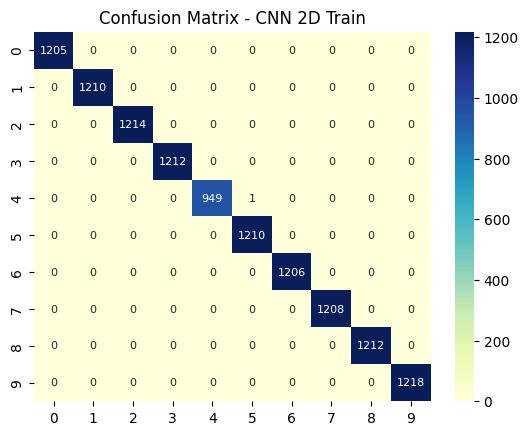

16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2025-06-10 10:05:04.803692: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 10:05:04.804027: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


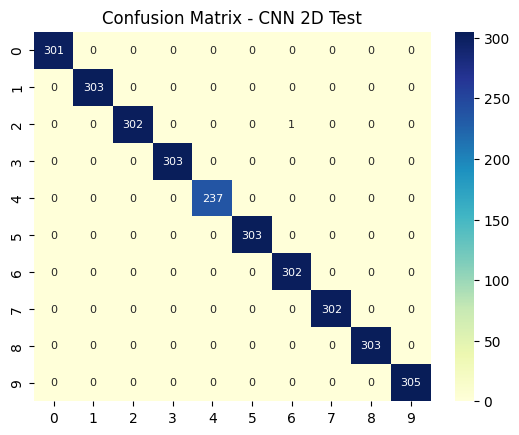

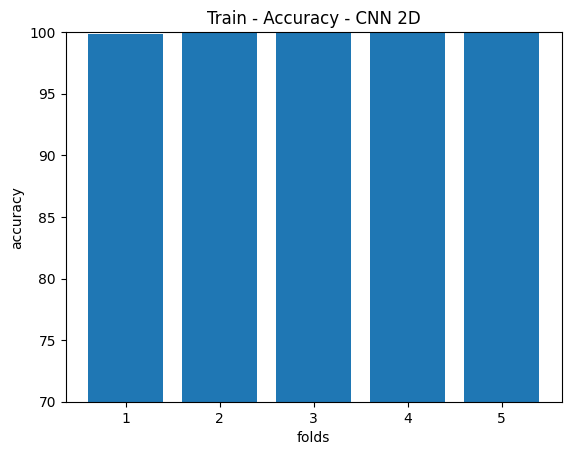

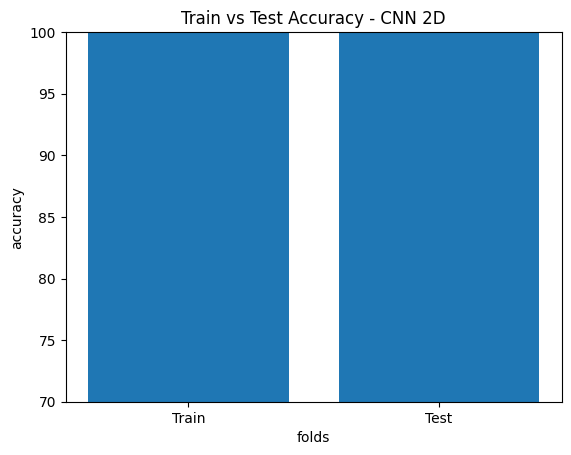

In [12]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()